# P01: The Pendulum

**Last revised:** Sep 17, 2021 by Heiko Hergert [hergert@frib.msu.edu] <br>
Based on original material by Dick Furnstahl [furnstahl.1@osu.edu]

<div class="alert alert-block alert-warning">

**First draft due:** Oct 11, 2021

</div>

# 1. Introduction
In this project, we will use the example of a pendulum to formulate a general strategy for implementing and solving the dynamics of physical system: We will set up and implement the governing equations of motion of an ideal pendulum, solve them numerically, visualize the solutions, and use a variety of techniques to test the validity along the way. Finally, we will add the dissipative effects that any realistic pendulum will experience. 



# 2. The Ideal Pendulum
## 2.1 Setup
We consider an ideal pendulum consisting of a mass $m$ that is suspended from the ceiling on a massless string of length $l$. When displaced from rest, the mass will perform oscillations under the influence of gravity, without any dissipative losses.


<div class="alert alert-block alert-info">

First, show that the Lagrangian of the pendulum is given by
$$
\begin{align}
  L(\phi,\dot{\phi})=\frac{1}{2}m l^2\dot{\phi}^2 + mgl\cos\phi\tag{1}
\end{align}
$$
(mind the choice of coordinate system and the signs).

Next, show that the Euler-Lagrange equations lead to the following equation of motion (EOM):

$$
\begin{align}
  \ddot\phi = -\frac{g}{l}\sin\phi
  \;.\tag{2}
\end{align}
$$

</div>

Type your work in the cell below. Make sure to switch the Cell Type to Markdown, e.g., via Jupyter's Cell menu. You can use LaTeX synatx in Jupyter Markdown to render formulas - double click the present cell to see examples.


#1 Finding the Lagrangian

As we know that $L = T - V$, we can write the kinetic energy in polar coordinates
$$
\begin{align}
T = \frac{1}{2}m(\dot{r}^2 + r^2 \dot{\phi}^2) = \frac{1}{2}m l^2 \dot{\phi}^2
\end{align}
$$

And for the potential:

$$
\begin{align}
V = -mgz = -mgl \cos{\phi} + V_0
\end{align}
$$

Hence,
$$
\begin{align}
L = \frac{1}{2}m l^2 \dot{\phi}^2 + mgl \cos{\phi}
\end{align}
$$

#2 Lagrange equations

From the Lagrangian we can derive:

$$
\begin{align}
\frac{d}{dt}\frac{\partial{L}}{\partial{\dot{\phi}}} - \frac{\partial{L}}{\partial{\phi}} = \frac{d}{dt}(ml^2 \dot{\phi}) + mgl \sin{\phi} = ml^2 \ddot{\phi} + mgl \sin{\phi} = 0 
\end{align}
$$

And from here:

$$
\begin{align}
\ddot{\phi} = -  \frac{g}{l} \sin{\phi} 
\end{align}
$$

## 2.2 Implementation
(If you are feeling up to it, you can check out SymPy's functionality for Lagrangian mechanics --- the documentation can be found [here](https://docs.sympy.org/latest/modules/physics/mechanics/lagrange.html). You will still need to be able to do some of the math on your own when you're taking an exam, so don't load off all the fun to SymPy.)

The pendulum's EOM is a second order, ***nonlinear*** differential equation. We are going to solve it exactly, which is only possible numerically, as well as with a series of controlled approximations that represent an **effective theory** of the pendulum. The leading-order effective theory corresponds to the frequently used small-angle approximation, which will provide us with an *analytic* solution for validating our results.

We will work to build up code in steps to find the solutions for the pendulum motion, in order to illustrate how a notebook evolves.  We usually don't create the polished version at once!

In [2]:
%matplotlib inline

In [3]:
import numpy as np
from scipy.integrate import odeint

import matplotlib.pyplot as plt
#plt.rcParams.update({'font.size': 18})


Recall from the Introduction notebook that Python's ODE solvers expect to be passed a vector containing first-order derivatives only. Fill in the following routine to adapt the right-hand side of the EOM to the required format, extracting the current solution from `u_vec` and returning `d(u_vec)/dt` to the ODE solver. 

In [5]:
def ode_rhs_exact(u_vec, t, *params):
    """ 
    Right-hand side (rhs) of the differential equation, with 
    u_vec = [\phi, \dot\phi] and params = [g, R].  Returns the list of
    d(u_vec)/dt, as prescribed by the differential equation.
    
    """
    phi, phidot =   u_vec[0], u_vec[1]     # extract phi and phidot from the passed vector
    g, R = params[0], params[1]              # extract g and R from the passed parameters
    return [u_vec[1] ,-g * np.sin(u_vec[0])/R ]

This is the main computational part of the code for now: Set up the initial conditions and run the ODE solver with the routine you have created to produce data.

In [8]:
# parameters
g = 9.8  # in mks units
R = 5    # radius in meters

# absolute and relative tolerances for ode solver
abserr = 1.0e-8
relerr = 1.0e-6

# initial conditions for [phi, phidot]
phi0 = np.pi/180 * 20.  # convert initial phi to radians
u0_vec = [phi0 , 0]

t_max = 15.  # integration time
t_pts = np.arange(0, t_max, 0.01)  # array of time points, spaced 0.01

# Integrate the differential equation and read off phi, phidot (note T!)
phi, phidot = odeint(ode_rhs_exact, u0_vec, t_pts, args=(g, R), 
                     atol=abserr, rtol=relerr).T

Now plot your solutions.

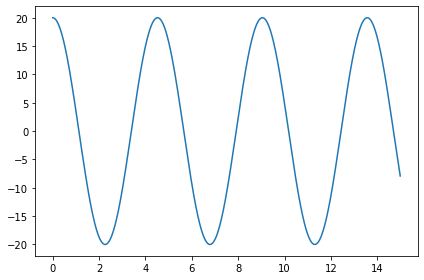

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(t_pts, 180./np.pi * phi)
fig.tight_layout()  # make the spacing of subplots nicer

<div class="alert alert-block alert-info">

Let us stop and assess our solution here. Does it make sense, given the behavior we would expect? I.e.,

- **Does the pendulum start at the correct angle?** 
- **Is the time behavior appropriate for an ideal, undamped pendulum?**
</div>

For future use, we now put the code into a function. We can use the syntax in the first line to assign default values to optional arguments (see below for calls to `solve_for_phi` with varying arguments).

In [10]:
def solve_for_phi(phi0, phidot0=0, t_min=0., t_max=1., g=9.8, R=5.):
    """
    Solve the equation of motion for an ideal pendulum.
    The result for t, \phi(t) and \dot\phi(t) are returned for a range
    t_min < t < t_max and a hardwired (for now) time step of 0.01 seconds.
    The ODE solver is odeint from scipy, with specified tolerances. 
    Units are mks and angles are in radians.
    """

    # absolute and relative tolerances for ode solver
    abserr = 1.0e-8
    relerr = 1.0e-6

    # initial conditions for [phi, phidot]
    u0_vec = [phi0, phidot0]

    t_pts = np.arange(t_min, t_max, 0.01)

    # Integrate the differential equation
    phi, phidot = odeint(ode_rhs_exact, u0_vec, t_pts, args=(g, R), 
                     atol=abserr, rtol=relerr).T
    
    return t_pts, phi, phidot 

<div class="alert alert-block alert-info">

**Check that the function works, i.e., gives you the same result as before.**

</div>

In [11]:
phi0 = np.pi/180 * 20.  # convert initial phi to radians
t_pts, phi, phidot = solve_for_phi(phi0, t_max=15.)

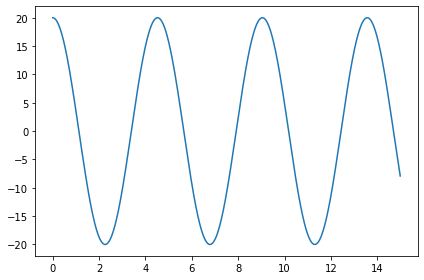

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(t_pts, 180./np.pi * phi)
fig.tight_layout()  # make the spacing of subplots nicer


# 2.3 Small-Angle Approximation

## 2.3.1 Derivation

In the following, we will use the terminology leading order (LO), next-to-leading order (NLO), next-to-next-to-leading order (N2LO) when we expand the Lagrangian --- specifically, the potential term --- for small values of the angle $\phi$. Note that it is customary to refer to the **first level of the approximation that yields any dynamics** as the leading order; i.e., if the first term of the expansion is a constant, it does not count, since constants in the Lagrangian have no impact on the motion of the pendulum.

<div class="alert alert-block alert-info">

Construct the Lagrangian of the pendulum in small-angle approximation through at least next-to-next-to-leading order, and the associated equation of motion. 

</div>

For the Lagrangian we will have:
$$
\begin{align}
L(\phi,\dot{\phi})=\frac{1}{2}m l^2\dot{\phi}^2 + mgl\cos\phi = \frac{1}{2}m l^2\dot{\phi}^2 + mgl - mgl \frac{{\phi}^2}{2} + mgl \frac{{\phi}^4}{24} - mgl \frac{{\phi}^6}{720} + ...
\end{align}
$$

## 2.3.2 Implementation

<div class="alert alert-block alert-info">

Implement a function for the RHS of the equation of motion in LO small-angle approximation. You can just copy and modify your routine for the exact solution, with an appropriate change of name.

</div>

In [13]:
def ode_rhs_lo(u_vec, t, *params):
    """ 
    Right-hand side (rhs) of the EOM for the ideal pendulum, with 
    u_vec = [\phi, \dot\phi] and params = [g, R].  Returns the list of
    d(u_vec)/dt, as prescribed by the differential equation.
    
    """
    
    return [u_vec[1] , -g*u_vec[0]/R]

In [26]:
def ode_rhs_nlo(u_vec, t, *params):
    """ 
    Right-hand side (rhs) of the EOM for the ideal pendulum, with 
    u_vec = [\phi, \dot\phi] and params = [g, R].  Returns the list of
    d(u_vec)/dt, as prescribed by the differential equation using NLO approximation.
    
    """
    
    return [u_vec[1] , -g*u_vec[0]/R + g * u_vec[0]**3/(6 * R)]

In [38]:
def ode_rhs_n2lo(u_vec, t, *params):
    """ 
    Right-hand side (rhs) of the EOM for the ideal pendulum, with 
    u_vec = [\phi, \dot\phi] and params = [g, R].  Returns the list of
    d(u_vec)/dt, as prescribed by the differential equation using NLO approximation.
    
    """
    
    return [u_vec[1] , -g*u_vec[0]/R + g * u_vec[0]**3/(6 * R) - g*u_vec[0]**5/(120 * R)]

Now we can put all RHS functions together into one solver function:

In [39]:
def solve_for_phi_all(phi0, phidot0=0, t_min=0., t_max=1., g=9.8, R=5.):
    """
    Solve the EOM for the ideal pendulum using the exact equation and the 
    small-angle approximation. The results for t, \phi(t) and \dot\phi(t), 
    are returned for a grid with t_min < t < t_max and a hardwired (for now) 
    spacing of 0.01 seconds. The ODE solver is odeint from scipy, with specified 
    tolerances. Units are mks and angles are in radians.
    """

    # absolute and relative tolerances for ode solver
    abserr = 1.0e-8
    relerr = 1.0e-6

    # initial conditions for [phi, phidot]
    u0_vec = [phi0, phidot0]

    t_pts = np.arange(t_min, t_max, 0.01)

    # Integrate the differential equations
    phi, phidot = odeint(ode_rhs_exact, u0_vec, t_pts, args=(g, R), 
                     atol=abserr, rtol=relerr).T
    phi_lo, phidot_lo = odeint(ode_rhs_lo, u0_vec, t_pts, args=(g, R), 
                     atol=abserr, rtol=relerr).T
    phi_nlo, phidot_nlo = odeint(ode_rhs_nlo, u0_vec, t_pts, args=(g, R), 
                     atol=abserr, rtol=relerr).T
    phi_n2lo, phidot_n2lo = odeint(ode_rhs_n2lo, u0_vec, t_pts, args=(g, R), 
                     atol=abserr, rtol=relerr).T
    return t_pts, phi, phidot, phi_lo, phidot_lo,phi_nlo, phidot_nlo , phi_n2lo, phidot_n2lo

## 2.3.3 Solutions and Discussion
Let's try it out!

In [40]:
phi0 = np.pi/180 * 20.
t_pts, phi, phidot, phi_lo, phidot_lo, phi_nlo, phidot_nlo, phi_n2lo, phidot_n2lo= solve_for_phi_all(phi0, t_max=15.)


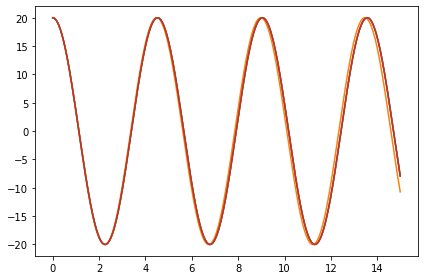

In [41]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(t_pts, 180./np.pi * phi)
ax.plot(t_pts, 180./np.pi * phi_lo)
ax.plot(t_pts, 180./np.pi * phi_nlo)
ax.plot(t_pts, 180./np.pi * phi_n2lo)
fig.tight_layout()  # make the spacing of subplots nicer


We could analyze the solutions at this stage, but instead let's improve the plot and see how to save it.

### More systematic plotting

Here we see examples of applying limits to the x and y axes as well as labels and a title.

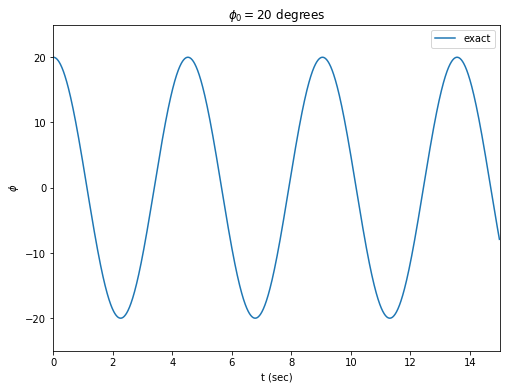

In [42]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(0.,15.)
ax.set_ylim(-25.,25.)
ax.set_xlabel('t (sec)')
ax.set_ylabel(r'$\phi$')
ax.set_title(r'$\phi_0 = 20$ degrees')

# DO NOT ERASE THE COMMA AND THE EMPTY SPACE!!!! 
# ax.plot() returns *two* objects, and the empty space after the comma means we do not assign it to a named
# variable because we do not need to use it in the following.

line_exact, = ax.plot(t_pts, 180./np.pi * phi, label='exact')
ax.legend()

# save the figure
fig.savefig('p01_pendulum_solutions.png', bbox_inches='tight')

### Now let's add some widgets!

We can use widgets to examine arbitrary angles.

In [43]:
from ipywidgets import interact, fixed
import ipywidgets as widgets

def rad_to_deg(theta_rad):
    """Take as input an angle in radians and return it in degrees."""
    return 180./np.pi * theta_rad

def deg_to_rad(theta_deg):
    """Take as input an angle in degrees and return it in radians."""
    return np.pi/180. * theta_deg


In [46]:
def plot_exact_and_small_angle(phi0_deg=0):
    phi0_rad = deg_to_rad(phi0_deg)
    t_pts, phi_rad, phidot_rad, phi_lo_rad, phidot_lo_rad, phi_nlo_rad, phidot_nlo_rad, phi_n2lo_rad, phidot_n2lo_rad= solve_for_phi_all(phi0_rad, t_max=15.)
    phi_deg = rad_to_deg(phi_rad)
    phi_lo_deg = rad_to_deg(phi_lo_rad)
    phi_nlo_deg = rad_to_deg(phi_nlo_rad)
    phi_n2lo_deg = rad_to_deg(phi_n2lo_rad)
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1,1,1)
    
    # DO NOT ERASE THE COMMA AND THE EMPTY SPACE!!!! 
    # ax.plot() returns *two* objects, and the empty space after the comma means we do not assign it to a named
    # variable because we do not need to use it in the following.
    
    
    line_lo, = ax.plot(t_pts, phi_lo_deg, label='LO')
    line_nlo, = ax.plot(t_pts, phi_nlo_deg, label='NLO')
    line_n2lo, = ax.plot(t_pts, phi_n2lo_deg, label='N2LO')
    line_exact, = ax.plot(t_pts, phi_deg, label='exact')
    
    
    ax.legend()
    ax.set_xlim(0.,15.)
    #ax.set_ylim(-90.,90.)
    ax.set_xlabel('t (sec)')
    ax.set_ylabel(r'$\phi$')
    ax.set_title(fr'$\phi_0 = {phi0_deg:.0f}$')
    plt.show()


In [47]:
interact(plot_exact_and_small_angle, phi0_deg=(0.,90.));

interactive(children=(FloatSlider(value=0.0, description='phi0_deg', max=90.0), Output()), _dom_classes=('widg…

In [48]:
# to avoid the jiggling and do some formatting
phi0_deg_widget = widgets.FloatSlider(min=0., max=120.0, step=0.1, value=0.,
                                     description=r'$\phi_0$ (degrees)',
                                     readout_format='.0f',
                                     continuous_update=False
                                    )
interact(plot_exact_and_small_angle, phi0_deg=phi0_deg_widget);

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='$\\phi_0$ (degrees)', max=1…

Now that we have played through the leading-order approximation of the Lagrangian, you may guess what is coming next.

<div class="alert alert-block alert-info">
    
Add NLO and N2LO corrections to the small angle expansion of $\sin\phi$, and analyze their impact on the accuracy of your result. 
    
- Generate data using **separate functions** for the RHS through different orders of the small-angle expansion, and plot them as separate curves in the same figure to make comparisons easier.
    
- Use the widgets to explore and identify ranges of angle where you notice interesting behavior, e.g., noticeable changes in the quality of the approximation. Create snapshot figures (or source code to produce them, as in the examples above) and use them to discuss your findings below.
</div>

# 3. Adding Damping 

Let us now consider a pendulum that is also subject to a drag force $\vec{F} = -\beta \dot{\vec{r}}$. 

## 3.1 Analytical Derivation

<div class="alert alert-block alert-info">

1. Construct the dissipation function.
2. Derive the Lagrange equations with the explicit drag term.
3. Solve the LO theory for the underdamped case and determine the time by which a small-amplitude oscillation has been reduced by a factor $1/e$.

</div>


## 3.2 Numerical Solution

<div class="alert alert-block alert-info">

1. Solve the exact and LO theories numerically for the underdamped case (make a suitable choice for $\beta$ and $m$).
2. Discuss qualitatively how the decay time of the exact solution changes for different initial amplitudes. 
3. How does the frequency change based on the strength on the damping?

</div>

